# Models

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
# Set file paths
data_path = '../data/'
admissions_file = os.path.join(data_path, 'hosp/admissions.csv.gz')
patients_file = os.path.join(data_path, 'hosp/patients.csv.gz')
transfers_file = os.path.join(data_path, 'hosp/transfers.csv.gz')
#labs_file = os.path.join(data_path, 'hosp/labevents.csv.gz')
procedures_file = os.path.join(data_path, 'hosp/procedures_icd.csv.gz')
#prescriptions_file = os.path.join(data_path, 'hosp/prescriptions.csv.gz')

In [3]:
# Load datasets
admissions = pd.read_csv(admissions_file, compression='gzip')
patients = pd.read_csv(patients_file, compression='gzip')
transfers = pd.read_csv(transfers_file, compression='gzip')
#labs = pd.read_csv(labs_file, compression='gzip')
procedures = pd.read_csv(procedures_file, compression='gzip')
#prescriptions = pd.read_csv(prescriptions_file, compression='gzip')

In [7]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546028 entries, 0 to 546027
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   subject_id            546028 non-null  int64 
 1   hadm_id               546028 non-null  int64 
 2   admittime             546028 non-null  object
 3   dischtime             546028 non-null  object
 4   deathtime             11790 non-null   object
 5   admission_type        546028 non-null  object
 6   admit_provider_id     546024 non-null  object
 7   admission_location    546027 non-null  object
 8   discharge_location    396210 non-null  object
 9   insurance             536673 non-null  object
 10  language              545253 non-null  object
 11  marital_status        532409 non-null  object
 12  race                  546028 non-null  object
 13  edregtime             379240 non-null  object
 14  edouttime             379240 non-null  object
 15  hospital_expire_f

In [8]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364627 entries, 0 to 364626
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   subject_id         364627 non-null  int64 
 1   gender             364627 non-null  object
 2   anchor_age         364627 non-null  int64 
 3   anchor_year        364627 non-null  int64 
 4   anchor_year_group  364627 non-null  object
 5   dod                38301 non-null   object
dtypes: int64(3), object(3)
memory usage: 16.7+ MB


In [5]:
transfers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2413581 entries, 0 to 2413580
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   subject_id   int64  
 1   hadm_id      float64
 2   transfer_id  int64  
 3   eventtype    object 
 4   careunit     object 
 5   intime       object 
 6   outtime      object 
dtypes: float64(1), int64(2), object(4)
memory usage: 128.9+ MB


In [6]:
procedures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859655 entries, 0 to 859654
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   subject_id   859655 non-null  int64 
 1   hadm_id      859655 non-null  int64 
 2   seq_num      859655 non-null  int64 
 3   chartdate    859655 non-null  object
 4   icd_code     859655 non-null  object
 5   icd_version  859655 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 39.4+ MB


In [10]:
transfers.hadm_id.isnull().value_counts()

False    2004604
True      408977
Name: hadm_id, dtype: int64

In [4]:
print(f'Shape of transfers df before dropping hadm_id null rows: {transfers.shape}')
transfers = transfers[~transfers.hadm_id.isnull()]
print(f'Shape of transfers df after dropping hadm_id null rows: {transfers.shape}')
transfers.hadm_id = transfers.hadm_id.astype(int)

Shape of transfers df before dropping hadm_id null rows: (2413581, 7)
Shape of transfers df after dropping hadm_id null rows: (2004604, 7)


In [13]:
transfers.head()

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime
0,10000032,22595853,33258284,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00
1,10000032,22595853,35223874,admit,Transplant,2180-05-06 23:30:00,2180-05-07 17:21:27
2,10000032,22595853,36904543,discharge,UNKNOWN,2180-05-07 17:21:27,NaN
3,10000032,22841357,34100253,discharge,UNKNOWN,2180-06-27 18:49:12,NaN
4,10000032,22841357,34703856,admit,Transplant,2180-06-26 21:31:00,2180-06-27 18:49:12


In [83]:
procedures.head()

,subject_id,hadm_id,seq_num,chartdate,icd_code,icd_version
0,10000032,22595853,1,2180-05-07,5491,9
1,10000032,22841357,1,2180-06-27,5491,9
2,10000032,25742920,1,2180-08-06,5491,9
3,10000068,25022803,1,2160-03-03,8938,9
4,10000117,27988844,1,2183-09-19,0QS734Z,10


## Preprocessing

In [14]:
##Avoid data leakage from the future

# Convert 'admittime' to datetime if it's not already
admissions['admittime'] = pd.to_datetime(admissions['admittime'])

# Create the 'prediction_time' column by adding 3 hours to 'admittime'
admissions['prediction_time'] = admissions['admittime'] + pd.Timedelta(hours=3)

In [87]:
## Removing future data from Transfers

# Merge 'admissions' with 'transfers' based on 'subject_id' and 'hadm_id'
merged_transfers = transfers.merge(admissions[['subject_id', 'hadm_id', 'admittime', 'prediction_time']],
                                   on=['subject_id', 'hadm_id'], how='left')

# Filter rows where 'in_time' is between 'admittime' and 'prediction_time'
merged_transfers = merged_transfers[(merged_transfers['intime'] >= merged_transfers['admittime']) &
                                    (merged_transfers['intime'] <= merged_transfers['prediction_time'])]

In [88]:
## Removing future data from Procedures

# Merge 'admissions' with 'transfers' based on 'subject_id' and 'hadm_id'
merged_procedures = procedures.merge(admissions[['subject_id', 'hadm_id', 'admittime', 'prediction_time']],
                                   on=['subject_id', 'hadm_id'], how='left')

# Filter rows where 'in_time' is between 'admittime' and 'prediction_time'
merged_procedures = merged_procedures[(merged_procedures['chartdate'] >= merged_procedures['admittime']) &
                                    (merged_procedures['chartdate'] <= merged_procedures['prediction_time'])]

In [89]:
patients.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000058,F,33,2168,2020 - 2022,NaN
3,10000068,F,19,2160,2008 - 2010,NaN
4,10000084,M,72,2160,2017 - 2019,2161-02-13


In [90]:
admissions.race.value_counts()

WHITE                                        336538
BLACK/AFRICAN AMERICAN                        75482
OTHER                                         19788
WHITE - OTHER EUROPEAN                        13972
UNKNOWN                                       13870
HISPANIC/LATINO - PUERTO RICAN                10903
HISPANIC OR LATINO                             8287
ASIAN                                          7809
ASIAN - CHINESE                                7644
WHITE - RUSSIAN                                6597
BLACK/CAPE VERDEAN                             6205
HISPANIC/LATINO - DOMINICAN                    6070
BLACK/CARIBBEAN ISLAND                         3875
BLACK/AFRICAN                                  3495
UNABLE TO OBTAIN                               3478
PATIENT DECLINED TO ANSWER                     2162
PORTUGUESE                                     2082
ASIAN - SOUTH EAST ASIAN                       1973
WHITE - EASTERN EUROPEAN                       1886
HISPANIC/LAT

In [5]:
category_mapping = {
    # WHITE categories
    'WHITE': 'WHITE',
    'WHITE - OTHER EUROPEAN': 'WHITE',
    'WHITE - RUSSIAN': 'WHITE',
    'WHITE - EASTERN EUROPEAN': 'WHITE',
    'WHITE - BRAZILIAN': 'WHITE',
    
    # BLACK/AFRICAN categories
    'BLACK/AFRICAN AMERICAN': 'BLACK/AFRICAN',
    'BLACK/CAPE VERDEAN': 'BLACK/AFRICAN',
    'BLACK/CARIBBEAN ISLAND': 'BLACK/AFRICAN',
    'BLACK/AFRICAN': 'BLACK/AFRICAN',
    
    # HISPANIC categories
    'HISPANIC OR LATINO': 'HISPANIC',
    'HISPANIC/LATINO - PUERTO RICAN': 'HISPANIC',
    'HISPANIC/LATINO - DOMINICAN': 'HISPANIC',
    'HISPANIC/LATINO - GUATEMALAN': 'HISPANIC',
    'HISPANIC/LATINO - ASIAN INDIAN': 'HISPANIC',
    'HISPANIC/LATINO - SALVADORAN': 'HISPANIC',
    'HISPANIC/LATINO - COLUMBIAN': 'HISPANIC',
    'HISPANIC/LATINO - MEXICAN': 'HISPANIC',
    'HISPANIC/LATINO - HONDURAN': 'HISPANIC',
    'HISPANIC/LATINO - CUBAN': 'HISPANIC',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'HISPANIC',
    
    # ASIAN categories
    'ASIAN': 'ASIAN',
    'ASIAN - CHINESE': 'ASIAN',
    'ASIAN - SOUTH EAST ASIAN': 'ASIAN',
    'ASIAN - ASIAN INDIAN': 'ASIAN',
    'ASIAN - KOREAN': 'ASIAN',
    
    # OTHER categories (updated and explicitly included)
    'AMERICAN INDIAN/ALASKA NATIVE': 'OTHER',
    'SOUTH AMERICAN': 'OTHER',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'OTHER',
    'PORTUGUESE': 'OTHER',
    'MULTIPLE RACE/ETHNICITY': 'OTHER',
    'UNKNOWN': 'OTHER',
    'UNABLE TO OBTAIN': 'OTHER',
    'PATIENT DECLINED TO ANSWER': 'OTHER'
}


In [6]:
# avoid too granular race info
admissions['race_grouped'] = admissions['race'].map(category_mapping)

In [17]:
admissions.race_grouped.value_counts()

WHITE            360519
BLACK/AFRICAN     89057
HISPANIC          32210
OTHER             24703
ASIAN             19751
Name: race_grouped, dtype: int64

In [7]:
# Merge datasets
# First, merge admissions and patients
merged_data = pd.merge(admissions, patients, on='subject_id', how='inner')

# Then, merge the result with transfers
# merged_data = pd.merge(merged_data, merged_transfers, on=['subject_id'], how='inner')

In [19]:
merged_data.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,edregtime,edouttime,hospital_expire_flag,prediction_time,race_grouped,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,...,2180-05-06 19:17:00,2180-05-06 23:30:00,0,2180-05-07 01:23:00,WHITE,F,52,2180,2014 - 2016,2180-09-09
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P784FA,EMERGENCY ROOM,HOME,Medicaid,...,2180-06-26 15:54:00,2180-06-26 21:31:00,0,2180-06-26 21:27:00,WHITE,F,52,2180,2014 - 2016,2180-09-09
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P19UTS,EMERGENCY ROOM,HOSPICE,Medicaid,...,2180-08-05 20:58:00,2180-08-06 01:44:00,0,2180-08-06 02:44:00,WHITE,F,52,2180,2014 - 2016,2180-09-09
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,Medicaid,...,2180-07-23 05:54:00,2180-07-23 14:00:00,0,2180-07-23 15:35:00,WHITE,F,52,2180,2014 - 2016,2180-09-09
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P39NWO,EMERGENCY ROOM,NaN,NaN,...,2160-03-03 21:55:00,2160-03-04 06:26:00,0,2160-03-04 02:16:00,WHITE,F,19,2160,2008 - 2010,NaN


In [8]:
# Merge datasets

# Feature engineering
merged_data['admittime'] = pd.to_datetime(merged_data['admittime'])
merged_data['dischtime'] = pd.to_datetime(merged_data['dischtime'])
merged_data['time_in_hospital'] = (merged_data['dischtime'] - merged_data['admittime']).dt.total_seconds() / 3600
merged_data = merged_data[merged_data['time_in_hospital'] >= 3]  # Exclude admissions less than 3 hours
merged_data['gender'] = merged_data['gender'].map({'M': 0, 'F': 1})
merged_data = pd.get_dummies(merged_data, columns=['race_grouped','gender', 'admission_type','insurance', 'admission_location'], drop_first=True)

In [21]:
merged_data.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admit_provider_id,discharge_location,language,marital_status,race,...,admission_location_CLINIC REFERRAL,admission_location_EMERGENCY ROOM,admission_location_INFORMATION NOT AVAILABLE,admission_location_INTERNAL TRANSFER TO OR FROM PSYCH,admission_location_PACU,admission_location_PHYSICIAN REFERRAL,admission_location_PROCEDURE SITE,admission_location_TRANSFER FROM HOSPITAL,admission_location_TRANSFER FROM SKILLED NURSING FACILITY,admission_location_WALK-IN/SELF REFERRAL
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,P49AFC,HOME,English,WIDOWED,WHITE,...,0,0,0,0,0,0,0,1,0,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,P784FA,HOME,English,WIDOWED,WHITE,...,0,1,0,0,0,0,0,0,0,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,P19UTS,HOSPICE,English,WIDOWED,WHITE,...,0,1,0,0,0,0,0,0,0,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,P06OTX,HOME,English,WIDOWED,WHITE,...,0,1,0,0,0,0,0,0,0,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,P39NWO,NaN,English,SINGLE,WHITE,...,0,1,0,0,0,0,0,0,0,0


In [98]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539366 entries, 0 to 546027
Data columns (total 46 columns):
 #   Column                                                     Non-Null Count   Dtype         
---  ------                                                     --------------   -----         
 0   subject_id                                                 539366 non-null  int64         
 1   hadm_id                                                    539366 non-null  int64         
 2   admittime                                                  539366 non-null  datetime64[ns]
 3   dischtime                                                  539366 non-null  datetime64[ns]
 4   deathtime                                                  11551 non-null   object        
 5   admit_provider_id                                          539362 non-null  object        
 6   discharge_location                                         395827 non-null  object        
 7   language            

In [24]:
 ## Group admission_location
    

In [99]:
print(merged_data.columns)


Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admit_provider_id', 'discharge_location', 'language', 'marital_status',
       'race', 'edregtime', 'edouttime', 'hospital_expire_flag',
       'prediction_time', 'anchor_age', 'anchor_year', 'anchor_year_group',
       'dod', 'time_in_hospital', 'race_grouped_BLACK/AFRICAN',
       'race_grouped_HISPANIC', 'race_grouped_OTHER', 'race_grouped_WHITE',
       'gender_1', 'admission_type_DIRECT EMER.',
       'admission_type_DIRECT OBSERVATION', 'admission_type_ELECTIVE',
       'admission_type_EU OBSERVATION', 'admission_type_EW EMER.',
       'admission_type_OBSERVATION ADMIT',
       'admission_type_SURGICAL SAME DAY ADMISSION', 'admission_type_URGENT',
       'insurance_Medicare', 'insurance_No charge', 'insurance_Other',
       'insurance_Private', 'admission_location_CLINIC REFERRAL',
       'admission_location_EMERGENCY ROOM',
       'admission_location_INFORMATION NOT AVAILABLE',
       'admission_locat

In [100]:
# # Define target variable y first (before dropping columns)
# y = merged_data['hospital_expire_flag']

# # Drop columns prone to target leakage or irrelevant for prediction
# # merged_data = merged_data.drop(columns=['admit_provider_id', ''deathtime', 'admittime', 'dischtime', 'ethnicity', 'admission_location', 'discharge_location', 'hospital_expire_flag'], errors='ignore')



In [9]:
#Selecting columns for x from merged data
selected_cols = ['anchor_age', 'insurance_Medicare', 'insurance_No charge', 'insurance_Other','gender_1','race_grouped_BLACK/AFRICAN',
       'race_grouped_HISPANIC', 'race_grouped_OTHER', 'race_grouped_WHITE',
       'insurance_Private', 'admission_location_EMERGENCY ROOM',
       'admission_location_INFORMATION NOT AVAILABLE',
       'admission_location_INTERNAL TRANSFER TO OR FROM PSYCH',
       'admission_location_PACU', 'admission_location_PHYSICIAN REFERRAL',
       'admission_location_PROCEDURE SITE',
       'admission_location_TRANSFER FROM HOSPITAL',
       'admission_location_TRANSFER FROM SKILLED NURSING FACILITY',
       'admission_location_WALK-IN/SELF REFERRAL']

In [23]:
len(selected_cols)

19

In [102]:
# # Define features X after dropping the target column

# X = merged_data[selected_cols]

## Stratified Sampling

In [10]:
# reduce the ratio of the training & validation sets based on y

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Split the data into training + validation and test sets (80% training + validation, 20% test)
train_val_data, test_data = train_test_split(merged_data, test_size=0.2, random_state=42, stratify=merged_data['hospital_expire_flag'])

# Further split the training + validation data into training and validation sets (80% training, 20% validation)
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42, stratify=train_val_data['hospital_expire_flag'])

# Separate the positive (1) and negative (0) classes in the training data
train_neg = train_data[train_data['hospital_expire_flag'] == 0]
train_pos = train_data[train_data['hospital_expire_flag'] == 1]

# Downsample the negative class to 10% of the original negative class size
train_neg_downsampled = resample(train_neg, 
                                 replace=False,    # Don't sample with replacement
                                 n_samples=int(0.1 * len(train_neg)),  # Downsample to 10% of the original negative class size
                                 random_state=42)  # Set random state for reproducibility

# Concatenate the downsampled negatives with the positive class (no downsampling)
train_data_balanced = pd.concat([train_pos, train_neg_downsampled])

# Shuffle the balanced training set
train_data_balanced = train_data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# The final datasets:
# - `train_data_balanced`: The downsampled training set (with 10% of negative class)
# - `val_data`: Validation set (with the original class distribution)
# - `test_data`: Test set (with the original class distribution)


In [115]:
train_data_balanced.hospital_expire_flag.value_counts(dropna=False)


0    33779
1     7400
Name: hospital_expire_flag, dtype: int64

In [116]:
val_data.hospital_expire_flag.value_counts(dropna=False)


0    84449
1     1850
Name: hospital_expire_flag, dtype: int64

In [117]:
test_data.hospital_expire_flag.value_counts(dropna=False)

0    105562
1      2312
Name: hospital_expire_flag, dtype: int64

In [11]:
# Define X and y for all datasets
X_train = train_data_balanced[selected_cols] #.drop(columns='hospital_expire_flag')
y_train = train_data_balanced['hospital_expire_flag']

X_val = val_data[selected_cols] #.drop(columns='hospital_expire_flag')
y_val = val_data['hospital_expire_flag']

X_test = test_data[selected_cols] #.drop(columns='hospital_expire_flag')
y_test = test_data['hospital_expire_flag']

In [119]:
X_train.columns


Index(['anchor_age', 'insurance_Medicare', 'insurance_No charge',
       'insurance_Other', 'gender_1', 'race_grouped_BLACK/AFRICAN',
       'race_grouped_HISPANIC', 'race_grouped_OTHER', 'race_grouped_WHITE',
       'insurance_Private', 'admission_location_EMERGENCY ROOM',
       'admission_location_INFORMATION NOT AVAILABLE',
       'admission_location_INTERNAL TRANSFER TO OR FROM PSYCH',
       'admission_location_PACU', 'admission_location_PHYSICIAN REFERRAL',
       'admission_location_PROCEDURE SITE',
       'admission_location_TRANSFER FROM HOSPITAL',
       'admission_location_TRANSFER FROM SKILLED NURSING FACILITY',
       'admission_location_WALK-IN/SELF REFERRAL'],
      dtype='object')

## Logistic Regression

In [25]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, lr_pred))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98    105562
           1       0.14      0.18      0.16      2312

    accuracy                           0.96    107874
   macro avg       0.56      0.58      0.57    107874
weighted avg       0.96      0.96      0.96    107874



## Random Forest Classifier

In [26]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, rf_pred))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97    105562
           1       0.10      0.19      0.13      2312

    accuracy                           0.95    107874
   macro avg       0.54      0.58      0.55    107874
weighted avg       0.96      0.95      0.95    107874



In [35]:
# Feature importance
feature_names = list(X_train.columns)

# Permutation feature importance
from sklearn.inspection import permutation_importance
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)
perm_imp_df = pd.DataFrame({'Feature': feature_names, 'Permutation Importance': result.importances_mean}).sort_values('Permutation Importance', ascending=False)
print(perm_imp_df)

                                              Feature  Permutation Importance
0                                          anchor_age                0.021729
1                                  insurance_Medicare                0.018122
8                                  race_grouped_WHITE                0.012170
10                  admission_location_EMERGENCY ROOM                0.010578
14              admission_location_PHYSICIAN REFERRAL                0.006928
9                                   insurance_Private                0.005154
5                          race_grouped_BLACK/AFRICAN                0.004947
7                                  race_grouped_OTHER                0.003188
18           admission_location_WALK-IN/SELF REFERRAL                0.001965
6                               race_grouped_HISPANIC                0.001175
4                                            gender_1                0.001096
15                  admission_location_PROCEDURE SITE           

In [27]:
# ROC-AUC Scores
models = {'Logistic Regression': lr, 'Random Forest': rf}
for name, clf in models.items():
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print(f"{name} ROC-AUC: {roc_auc:.2f}")


Logistic Regression ROC-AUC: 0.77
Random Forest ROC-AUC: 0.72


## LightGBM Classifier

In [36]:
import lightgbm as lgb
params = {
    'objective': 'binary',  # or your specific objective
    'num_leaves': 31, 
    'metric': ['auc','binary_error'],  # or your specific evaluation metric
    'verbose': 1,  # -1 means no output, you can set to 1 or 2 for verbosity
    'num_boost_round' : 1000
}

model = lgb.train(
    params,
    lgb.Dataset(X_train, label=y_train),
    valid_sets=[lgb.Dataset(X_val, label=y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=5)]
)

/Users/warunijaya/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7400, number of negative: 33779
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 41179, number of used features: 19
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.179703 -> initscore=-1.518359
[LightGBM] [Info] Start training from score -1.518359
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 0.776078	valid_0's binary_error: 0.0209388


In [37]:
y_test.value_counts(dropna=False)

0    105562
1      2312
Name: hospital_expire_flag, dtype: int64

In [38]:
# lgbm_pred = model.predict(X_test)
ypred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_binary = (ypred >= 0.5).astype(int)
print("LightGBM Classification Report:\n", classification_report(y_test.values, y_pred_binary))


LightGBM Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    105562
           1       0.70      0.03      0.06      2312

    accuracy                           0.98    107874
   macro avg       0.84      0.51      0.52    107874
weighted avg       0.97      0.98      0.97    107874



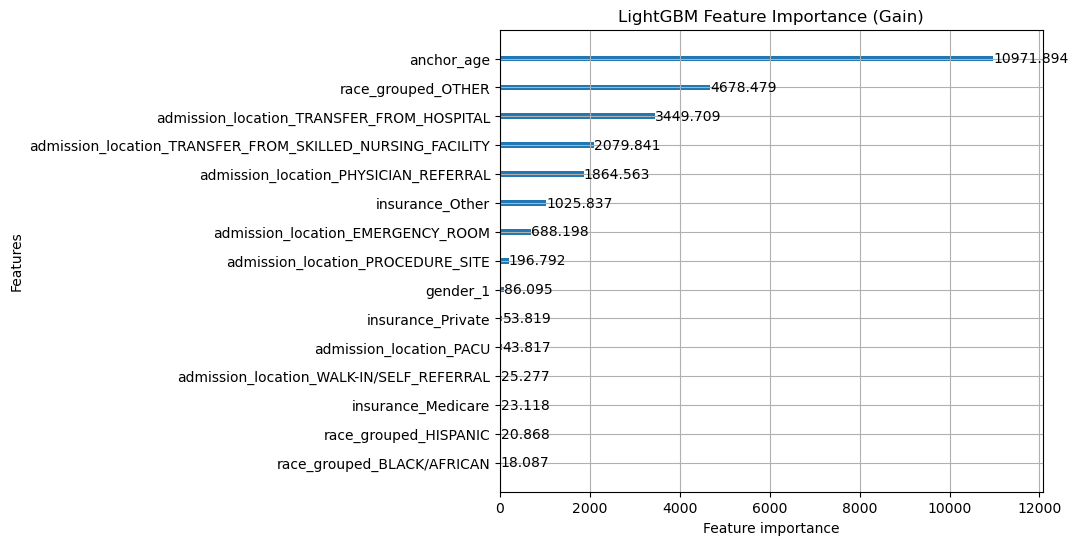

In [39]:
# Plot feature importance using Gain
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

## Neural Network

In [12]:
# Neural Network with PyTorch
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(16, 4)
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.output(x))
        return x

In [14]:
print(X_train.dtypes)


anchor_age                                                   int64
insurance_Medicare                                            bool
insurance_No charge                                           bool
insurance_Other                                               bool
gender_1                                                      bool
race_grouped_BLACK/AFRICAN                                    bool
race_grouped_HISPANIC                                         bool
race_grouped_OTHER                                            bool
race_grouped_WHITE                                            bool
insurance_Private                                             bool
admission_location_EMERGENCY ROOM                             bool
admission_location_INFORMATION NOT AVAILABLE                  bool
admission_location_INTERNAL TRANSFER TO OR FROM PSYCH         bool
admission_location_PACU                                       bool
admission_location_PHYSICIAN REFERRAL                         

In [15]:
X_train = X_train.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

In [16]:
print(X_train.dtypes)


anchor_age                                                   int64
insurance_Medicare                                           int64
insurance_No charge                                          int64
insurance_Other                                              int64
gender_1                                                     int64
race_grouped_BLACK/AFRICAN                                   int64
race_grouped_HISPANIC                                        int64
race_grouped_OTHER                                           int64
race_grouped_WHITE                                           int64
insurance_Private                                            int64
admission_location_EMERGENCY ROOM                            int64
admission_location_INFORMATION NOT AVAILABLE                 int64
admission_location_INTERNAL TRANSFER TO OR FROM PSYCH        int64
admission_location_PACU                                      int64
admission_location_PHYSICIAN REFERRAL                        i

In [20]:
X_val = X_val.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
X_test = X_test.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

In [21]:
# Prepare data for PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [22]:
# Initialize model, loss function, and optimizer
input_size = X_train.shape[1]
model = NeuralNetwork(input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Training loop
epochs = 20
batch_size = 32
for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train_tensor.size(0))
    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss.item():.4f}")

Epoch 1/20, Validation Loss: 0.2674
Epoch 2/20, Validation Loss: 0.2205
Epoch 3/20, Validation Loss: 0.2226
Epoch 4/20, Validation Loss: 0.2065
Epoch 5/20, Validation Loss: 0.1856
Epoch 6/20, Validation Loss: 0.1864
Epoch 7/20, Validation Loss: 0.2004
Epoch 8/20, Validation Loss: 0.1964
Epoch 9/20, Validation Loss: 0.2204
Epoch 10/20, Validation Loss: 0.1921
Epoch 11/20, Validation Loss: 0.1810
Epoch 12/20, Validation Loss: 0.2119
Epoch 13/20, Validation Loss: 0.1855
Epoch 14/20, Validation Loss: 0.1908
Epoch 15/20, Validation Loss: 0.2338
Epoch 16/20, Validation Loss: 0.2037
Epoch 17/20, Validation Loss: 0.2230
Epoch 18/20, Validation Loss: 0.1992
Epoch 19/20, Validation Loss: 0.2076
Epoch 20/20, Validation Loss: 0.2082


In [28]:
# Testing
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor).numpy()
    nn_pred = (test_outputs > 0.5).astype(int).flatten()
print("Neural Network Classification Report:\n", classification_report(y_test, nn_pred))

# ROC-AUC Scores
models = {'Logistic Regression': lr, 'Random Forest': rf}
for name, clf in models.items():
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print(f"{name} ROC-AUC: {roc_auc:.2f}")

nn_roc_auc = roc_auc_score(y_test, test_outputs)
print(f"Neural Network ROC-AUC: {nn_roc_auc:.2f}")

Neural Network Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    105562
           1       0.20      0.05      0.08      2312

    accuracy                           0.98    107874
   macro avg       0.59      0.52      0.53    107874
weighted avg       0.96      0.98      0.97    107874

Logistic Regression ROC-AUC: 0.77
Random Forest ROC-AUC: 0.72
Neural Network ROC-AUC: 0.77
